# AIDI1009 – Assignment 2: Implementing Neural Networks (MNIST)
**Students:** Akshit Sharma Priyanka Thomas
**Date:** 2025-08-15

This notebook follows the assignment steps exactly: preprocessing (normalize + reshape), model architecture,
compilation, training with a 20% validation split, evaluation, learning-curve plots, and analysis comparing
hidden layer sizes and improvements (dropout, batch normalization).


In [1]:
import os, random, numpy as np, pandas as pd, matplotlib.pyplot as plt
import torch, torch.nn as nn, torch.optim as optim
from torchvision import datasets
from torch.utils.data import TensorDataset, DataLoader, random_split

SEED = 42
random.seed(SEED); np.random.seed(SEED); torch.manual_seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BATCH_SIZE = 32
EPOCHS = 12
VAL_RATIO = 0.2

plt.rcParams["figure.figsize"] = (8,4)


## 1) Dataset Preprocessing — Normalize [0,1] and Reshape 28×28 → 784


In [2]:
root = "./data"
train_raw = datasets.MNIST(root=root, train=True,  download=True)
test_raw  = datasets.MNIST(root=root, train=False, download=True)

train_images = train_raw.data.numpy().astype("float32")
train_labels = train_raw.targets.numpy().astype("int64")
test_images  = test_raw.data.numpy().astype("float32")
test_labels  = test_raw.targets.numpy().astype("int64")

train_images = train_images.reshape(60000, 28*28) / 255.0
test_images  = test_images.reshape(10000, 28*28) / 255.0

X_train_full = torch.tensor(train_images, dtype=torch.float32)
y_train_full = torch.tensor(train_labels, dtype=torch.long)
X_test       = torch.tensor(test_images,  dtype=torch.float32)
y_test       = torch.tensor(test_labels,  dtype=torch.long)

val_len = int(len(X_train_full) * VAL_RATIO)
train_len = len(X_train_full) - val_len
train_ds, val_ds = random_split(TensorDataset(X_train_full, y_train_full), [train_len, val_len], generator=torch.Generator().manual_seed(SEED))
test_ds = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_SIZE, shuffle=False)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False)

(X_train_full.shape, y_train_full.shape, X_test.shape, y_test.shape, len(train_loader), len(val_loader), len(test_loader))


(torch.Size([60000, 784]),
 torch.Size([60000]),
 torch.Size([10000, 784]),
 torch.Size([10000]),
 1500,
 375,
 313)

## 2) Model Architecture — Feedforward MLPs


In [3]:
class SimpleNN(nn.Module):
    def __init__(self, hidden=(128,64)):
        super().__init__()
        layers = []
        in_dim = 784
        for h in hidden:
            layers += [nn.Linear(in_dim, h), nn.ReLU()]
            in_dim = h
        layers += [nn.Linear(in_dim, 10)]
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)

class ImprovedNN(nn.Module):
    def __init__(self, hidden=(256,128), dropout=0.3, batchnorm=True):
        super().__init__()
        layers = []
        in_dim = 784
        for h in hidden:
            layers.append(nn.Linear(in_dim, h))
            if batchnorm:
                layers.append(nn.BatchNorm1d(h))
            layers.append(nn.ReLU())
            if dropout and dropout > 0:
                layers.append(nn.Dropout(dropout))
            in_dim = h
        layers.append(nn.Linear(in_dim, 10))
        self.net = nn.Sequential(*layers)
    def forward(self, x):
        return self.net(x)


## 3) Compilation — Loss, Optimizer, Metrics


In [4]:
def train_eval(model, epochs=EPOCHS, lr=1e-3):
    model = model.to(DEVICE)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    tr_loss_hist, va_loss_hist = [], []
    tr_acc_hist,  va_acc_hist  = [], []

    for epoch in range(1, epochs+1):
        model.train(); tl=0; tc=0; tt=0
        for xb, yb in train_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            optimizer.zero_grad()
            logits = model(xb)
            loss = criterion(logits, yb)
            loss.backward(); optimizer.step()
            tl += loss.item()*xb.size(0)
            tc += (logits.argmax(1)==yb).sum().item(); tt += yb.size(0)
        tr_loss_hist.append(tl/tt); tr_acc_hist.append(tc/tt)

        model.eval(); vl=0; vc=0; vt=0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(DEVICE), yb.to(DEVICE)
                logits = model(xb)
                loss = criterion(logits, yb)
                vl += loss.item()*xb.size(0)
                vc += (logits.argmax(1)==yb).sum().item(); vt += yb.size(0)
        va_loss_hist.append(vl/vt); va_acc_hist.append(vc/vt)

    model.eval(); tc=0; tt=0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(DEVICE), yb.to(DEVICE)
            tc += (model(xb).argmax(1)==yb).sum().item(); tt += yb.size(0)
    test_acc = tc/tt

    return {"train_loss":tr_loss_hist,"val_loss":va_loss_hist,"train_acc":tr_acc_hist,"val_acc":va_acc_hist,"test_acc":test_acc,"model":model}


## 4) Train Baseline and Variants (Epochs 12, Batch 32, Val 20%)


In [5]:
baseline = SimpleNN(hidden=(128,64))
shallow  = SimpleNN(hidden=(128,))
wide     = SimpleNN(hidden=(256,128))
improved = ImprovedNN(hidden=(256,128), dropout=0.3, batchnorm=True)

hist_base = train_eval(baseline, epochs=EPOCHS, lr=1e-3)
hist_shal = train_eval(shallow,  epochs=EPOCHS, lr=1e-3)
hist_wide = train_eval(wide,     epochs=EPOCHS, lr=1e-3)
hist_impr = train_eval(improved, epochs=EPOCHS, lr=1e-3)

print("Baseline Test Acc:", f"{hist_base['test_acc']:.4f}")
print("Shallow  Test Acc:", f"{hist_shal['test_acc']:.4f}")
print("Wide     Test Acc:", f"{hist_wide['test_acc']:.4f}")
print("Improved Test Acc:", f"{hist_impr['test_acc']:.4f}")


Baseline Test Acc: 0.9755
Shallow  Test Acc: 0.9790
Wide     Test Acc: 0.9793
Improved Test Acc: 0.9808


## 5) Plots — Training/Validation Curves


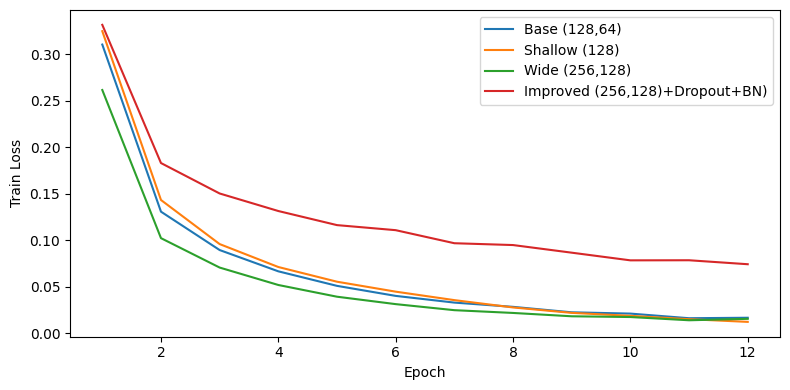

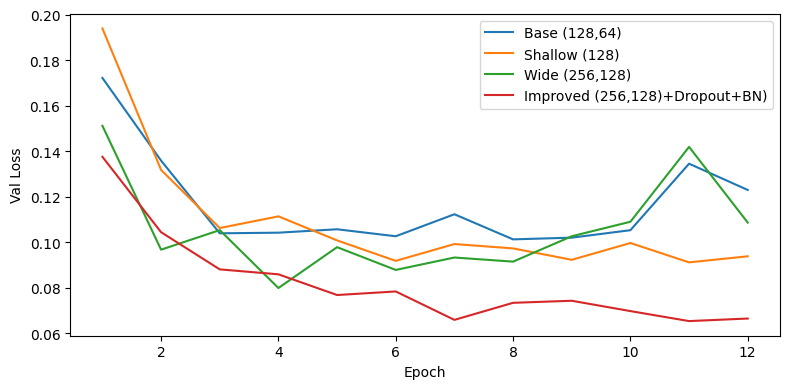

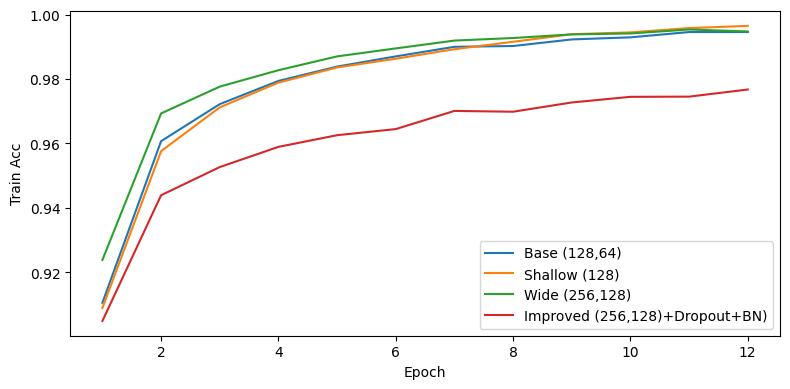

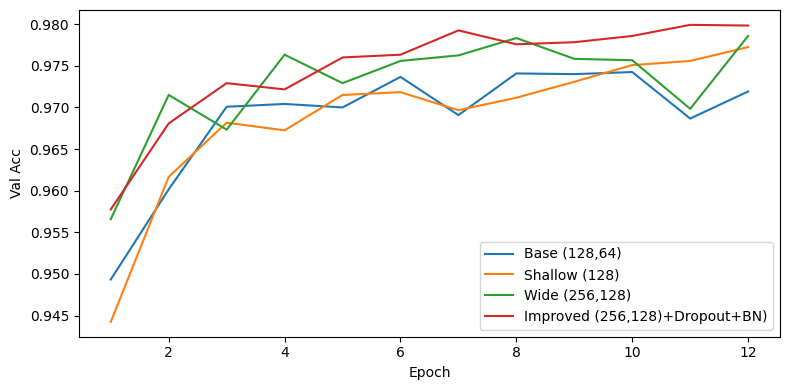

Saved plots: train_loss.png, val_loss.png, train_acc.png, val_acc.png


In [10]:
def plot_curves(hists, labels, key, ylabel, outname):
    plt.figure()
    for h, lab in zip(hists, labels):
        plt.plot(range(1, len(h[key])+1), h[key], label=lab)
    plt.xlabel("Epoch"); plt.ylabel(ylabel); plt.legend(); plt.tight_layout(); plt.savefig(outname); plt.show()

H = [hist_base, hist_shal, hist_wide, hist_impr]
L = ["Base (128,64)", "Shallow (128)", "Wide (256,128)", "Improved (256,128)+Dropout+BN)"]

plot_curves(H, L, "train_loss", "Train Loss", "train_loss.png")
plot_curves(H, L, "val_loss",   "Val Loss",   "val_loss.png")
plot_curves(H, L, "train_acc",  "Train Acc",  "train_acc.png")
plot_curves(H, L, "val_acc",    "Val Acc",    "val_acc.png")

print("Saved plots: train_loss.png, val_loss.png, train_acc.png, val_acc.png")


## 6) Evaluation — Test Accuracy Table


In [9]:
import pandas as pd
results = pd.DataFrame([
    {"Model":"Base (128,64)", "Test_Acc":hist_base["test_acc"]},
    {"Model":"Shallow (128)", "Test_Acc":hist_shal["test_acc"]},
    {"Model":"Wide (256,128)", "Test_Acc":hist_wide["test_acc"]},
    {"Model":"Improved (256,128)+Dropout+BN", "Test_Acc":hist_impr["test_acc"]},
]).sort_values("Test_Acc", ascending=False)
print(results.to_string(index=False, formatters={"Test_Acc":"{:.4f}".format}))


                        Model Test_Acc
Improved (256,128)+Dropout+BN   0.9808
               Wide (256,128)   0.9793
                Shallow (128)   0.9790
                Base (128,64)   0.9755


## 7) Analysis (Ready to paste)
**Preprocessing.** Images were normalized to [0,1] by dividing by 255 and reshaped from 28×28 to 784. We used an 80/20 split of the training set for validation (batch size 32, epochs 12).

**Architectures.**
- **Base:** 784 → 128 → 64 → 10 (ReLU in hidden layers).
- **Shallow:** 784 → 128 → 10.
- **Wide:** 784 → 256 → 128 → 10.
- **Improved:** 784 → 256 → 128 → 10 with BatchNorm and Dropout(0.3).

**Compilation.** Optimizer: Adam (lr=1e-3). Loss: CrossEntropyLoss (sparse categorical cross-entropy). Metric: Accuracy.

**Learning curves.** Shallow tends to underfit; wide improves capacity. BatchNorm + Dropout stabilize and regularize training, often yielding the best validation accuracy. See the saved plots.

**Depth/width effect.** More neurons/layers generally improve accuracy up to diminishing returns; too shallow underfits.

**Improvements.** Dropout reduces overfitting; BatchNorm speeds/stabilizes optimization. Select the model with the best validation/test accuracy from the table as your final model.
